# Business Overview
## Context
Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). 

## Problem
So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

## Solution
Build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. We'll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.


# Technical Overview
## Problem
Given a set of comments as input, our model has to predict in which of the following 6 classes each comment is classified:
- Toxic
- Severe toxic
- Obscene
- Threat
- Insult
- Identity_hate

From the train data set, the model has to learn how to classify each comment. Knowing that, the model applies its learning on the test data set to predict the classifications of each comment. 

## Class Properties Assumptions
According to the classes, we cannot answer with exactitude what are the properties that define each class. What are the differences between a comment classified as toxic versus severe toxic? Normally, we would have asked the question to the person that create those classes.

Using the definition of each class, we assume the following definitions:
- Toxic: Only few parts of the comment are using words like fuck, suck or any other similar word.
- Severe toxic: All parts of the comment is toxic and the ratio between bad words like fuck, suck or similar word and the number of words is closer to 1.
- Obscene: All comments containg exagerated abominations or have sexual content.
- Threat: All comments containing menace (severe or simply a warning) to other people or wishing some punishments like insisting on banning someone.
- Insult: All comments insulting other people like telling that someone is stupid, imbecile or any other similar insults.
- Identity_hate: All comments having racist content, sexual orientation hate or religion hate.

These definitions could be used as a set of rules to follow to increase the accuracy of the classification of comments.

## Mathematical Problem Definition
Let $X = (x_1,x_2,\ldots,x_n) \in \mathcal{C}^n$ be the vector of comments where $\mathcal{C}$ is a vector of words $(w_1, w_2, \ldots, w_k)$ defining a comment and $n$ is the length of $X$ which is the number of comments in the data set. The position of the comments in $X$ does not matter.
We note the category vector as $Y = (y_1,y_2,\ldots,y_m) \in \mathbb{M}_{n \times m}([0,1])$ where each of them is predicted by the estimator vector $\hat{Y} = (\hat{y}_1,\hat{y}_2,\ldots,\hat{y}_m) \in \mathbb{M}_{n \times m}([0,1])$ associated to a bias vector $\epsilon = (\epsilon_1, \epsilon_2, \ldots, \epsilon_m) \in \mathbb{M}_{n \times m}([0,1])$. The notation $Y \in \mathbb{M}_{n \times m}([0,1])$ means that $Y$ is a $n \times m$ matrix where each value $y_{i,j}$ is in $[0,1]$. Finally, let $C = (c_1,c_2,\ldots, c_m)$ be the class vector.

Let $f : \mathcal{C}^n \longrightarrow \mathbb{M}_{n \times m}([0,1])$ be a model defined by $f(X) = \hat{Y}$ where $Y = \hat{Y} + \epsilon$ with $+$ the matrix addition operator.
The goal is to find a model $f$ such that the bias $\epsilon$ is minimized when $f$ is applied on $X$.

## Evaluation Metric
We use the __Receiver Operating Characteristic Area Under Curve (ROCAUC)__ function to evaluate the score of the column $i$ noted $R(Y_i, \hat{Y}_i)$. To obtain the multi-class ROCAUC final score, we define the cost function as
$$S(Y, \hat{Y}) = \frac{1}{m} \sum_{i = 1}^m R(Y_i, \hat{Y}_i)$$
where $0 \leq R(Y_i, \hat{Y}_i) \leq 1$ is the ROCAUC function.

The goal is to maximize $S(Y, \hat{Y})$ where $S(Y, \hat{Y}) = 1$ means that the model is perfect. 


# Data Acquisition
The goal is to get the train and test data sets and extract basic information before starting the data exploratory phase.

## Data Source
The data come from Kaggle and are downloaded __[here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)__.

## Dataset Basic Information
We need to know how much data do we have in our data sets to help us determining a list of algorithms that will suit better to solve the problem.
- Number of rows
- Number of columns
- Percentage: number of rows of a data set / total number of rows of test + train sets * 100
- Average, Min and Max length of comments (number of words and number of characters)

In [1]:
import pandas
import numpy as np
import seaborn as graph
import matplotlib.pyplot as plt
import itertools
import re

from string import punctuation

from IPython.display import display

#from nltk.corpus import stopwords
#from nltk import word_tokenize

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

from PlotUtils import *
from Model import *
from NewFeatureGenerator import *
from DataExploratory import *

## Remove the scientific notation. Keep only 3 decimals.
np.set_printoptions(suppress=True)
pandas.set_option('display.float_format', lambda x: '%.4f' % x)


train = pandas.read_csv("dataset/train.csv")
train_number_of_rows = len(train.index)
train_number_of_cols = len(train.columns)
print("Train set - Number of rows: ", train_number_of_rows)
print("Train set - Number of columns: ", train_number_of_cols)

test = pandas.read_csv("dataset/test.csv")
test_number_of_rows = len(test.index)
test_number_of_cols = len(test.columns)
print("\nTest set - Number of rows: ", test_number_of_rows)
print("Test set - Number of columns: ", test_number_of_cols)

number_of_classes = train_number_of_cols - test_number_of_cols
print("\nNumber of output classes: ", number_of_classes)

output_classes = train.columns.values[test_number_of_cols:]
print("Output classes: ", output_classes)

train_input = train[train.columns[0:test_number_of_cols]]
train_output = train[output_classes]

percentage_test = round(test_number_of_rows / (test_number_of_rows + train_number_of_rows) * 100, 2)
print("The test set contains ", percentage_test, "% of the overall data sets.")

words_frequency = GetWordFrequency(train.comment_text)
print("Number of unique words: ", len(words_frequency))

lengths = train.comment_text.str.len()
print("\nLength of the smallest comment: ", lengths.min())
print("Length of the largest comment: ", lengths.max())
print("Average length of comments: ", lengths.mean())
print("Standard deviation of the length of comments: ", lengths.std())

Train set - Number of rows:  159571
Train set - Number of columns:  8

Test set - Number of rows:  153164
Test set - Number of columns:  2

Number of output classes:  6
Output classes:  ['toxic' 'severe_toxic' 'obscene' 'threat' 'insult' 'identity_hate']
The test set contains  48.98 % of the overall data sets.
Number of unique words:  470340

Length of the smallest comment:  6
Length of the largest comment:  5000
Average length of comments:  394.0732213246768
Standard deviation of the length of comments:  590.7202819048919


## Applicable Algorithms
The goal is to find a list of algorithms that can be applied to our problem.
- We know the possible outputs where each comment has to be classified hence we seek for a supervised algorithm.
- As the problem states, the output is a multi-classification which explain why the multi-class AUROC metric has been chosen.
- We have to analyse comments (texts) that is part of the Natural Language Processing (NLP). 
- We have 159571 comments in the train set which is a small data set.

According to those points, supervised algorithms for classification related to the NLP are mostly suitable to solve the problem. However, regression algorithms should work because we can extract features from the comments.

We will try the following algorithms:
- Naive Bayes Classification (NB): https://web.stanford.edu/class/cs124/lec/naivebayes.pdf
- Support Vector Machine (SVM): https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
- Maximum Entropy Classifier (http://www.kamalnigam.com/papers/maxent-ijcaiws99.pdf)
- Recurrent Convolutional Neural Networks (http://www.aaai.org/ocs/index.php/AAAI/AAAI15/paper/download/9745/9552)

# Data Exploratory
The goal is to explore the training and test sets to understand and visualize how the comments are written and how they are classified.

Comments can be written the following ways knowing that emotions are generally a strong factor that influances how people write their comments:
- Normal sentences without any of the previous ways specified above.
- Lower case or upper case. We need to check if this has influance on the classification.
- Invisible characters like tabulations, carriage returns, spaces. 
- Words with repeated characters (e.g. suckkkkkkkk).
- Abusive usage of puctuation like !?
- Unicode special characters like Chinese characters or any other languages using caligraphic characters.
- Words with grammar, spelling or typing errors like the word "btich" which should be "bitch".
- Abbreviations 
- Bad words hidden like "sh*t"
- Other special characters (e.g. &%?/"!)
- Words with same meaning (e.g. fuck, fucking, fucker)
- Numbers

## Not Applicable or Null Comments
Let's check if there are comments containing NA or being empty.


In [2]:
print("Number of empty comments in train set: ", len(train[train['comment_text'].isnull()]))
print("Number of empty comments in test set: ", len(test[test['comment_text'].isnull()]))

train.comment_text.fillna("unknown", inplace=True)
test.comment_text.fillna("unknown", inplace=True)
print("Number of NA in comments of train set: ", len(train[train['comment_text'] == 'unknown']))
print("Number of NA in comments of test set: ", len(test[test['comment_text'] == 'unknown']))

Number of empty comments in train set:  0
Number of empty comments in test set:  0
Number of NA in comments of train set:  0
Number of NA in comments of test set:  0


We conclude that there are neither NA nor null values in both data sets. 

## Classification of Comments


 Number of comments for each class: 
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


[Text(0,0,'toxic'),
 Text(0,0,'severe_toxic'),
 Text(0,0,'obscene'),
 Text(0,0,'threat'),
 Text(0,0,'insult'),
 Text(0,0,'identity_hate')]

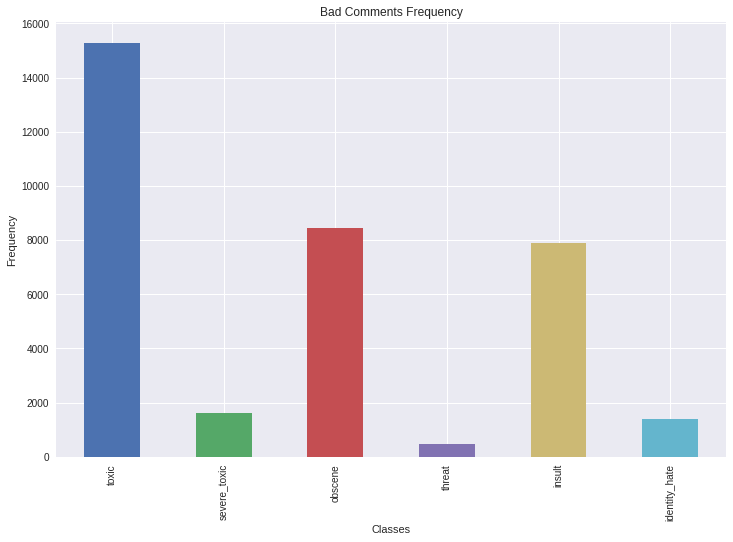

In [3]:
classes_frequency = pandas.Series.from_array(train[output_classes].sum())
print("\n Number of comments for each class: \n", classes_frequency)

plt.figure(figsize=(12, 8))
ax = classes_frequency.plot(kind='bar')
ax.set_title("Bad Comments Frequency")
ax.set_xlabel("Classes")
ax.set_ylabel("Frequency")
ax.set_xticklabels(output_classes)

## Assumptions
1. Upper case words are mostly subject to bad comments.
2. Abusive invisible characters are there to dissimulate bad comments. This is a way to write an inappropriate comment and try to bypass the algorithm to not get blocked.
3. Words containing abusive repeated characters means frustration and are mostly bad.
4. Abusive usage of exclamation marks normally means that people are angry and the risks of containing bad comment are high.
5. Special characters like 'sh*t' hide bad words and are mostly in bad comments.
6. Smaller comments (less than 10 words) are mostly bad comments because people may write sentences like 'Fuck u'.
7. Foreign languages using caligraphic unicode characters (e.g. Chinese characters) are used to hide bad comments because they use their language to not be recognized.
8. Numbers are used to dissimulate a bad word like "5h1t" but it should be a rare case.
9. Repeated words or sentences are mostly used in bad comments.

## Feature Extraction
Let's add new features to the train set according to the assumptions to show if those assumptions are true or false. To prove if they are true or false, we will check the correlation between the new features and the classes. 

,identity_hate,insult,obscene,severe_toxic,threat,toxic
comment_length,-0.0136,-0.0451,-0.0429,0.0101,-0.0080,-0.0545
number_of_capitals,0.0536,0.0759,0.0817,0.1434,0.0336,0.0912
ratio_capitals_length,0.0937,0.1704,0.1825,0.1692,0.0556,0.2208
exclamation_marks,0.0060,0.0270,0.0244,0.0606,0.0342,0.0373
ratio_exclamation_marks_length,0.0393,0.1027,0.1082,0.0931,0.0378,0.1321
question_marks,-0.0005,0.0049,0.0054,-0.0045,-0.0039,0.0278
ratio_question_marks_length,0.0008,0.0108,0.0144,0.0007,-0.0059,0.0310
carriage_returns,0.0025,-0.0088,-0.0027,0.0198,-0.0002,-0.0104
ratio_carriage_returns_length,0.0264,0.0747,0.0808,0.0498,0.0212,0.0822
special_chars,0.0138,0.0072,0.0158,0.0162,0.0024,0.0171


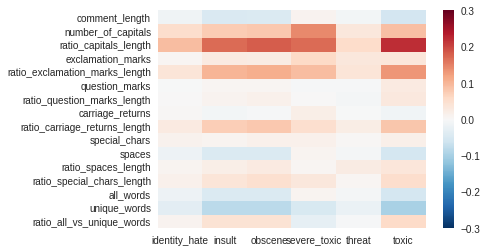

In [4]:
## Assumption 1      
train['comment_length'] = [comment_length for comment_length in comment_lengths(train['comment_text'])]

train['number_of_capitals'] = [capitals for capitals in comments_capitals_counter(train['comment_text'])]

train['ratio_capitals_length'] = [ratio for ratio in ratio_feature_vs_length(train['number_of_capitals'], train['comment_length'])]


## Assumption 2
train['carriage_returns'] = [carriage_returns for carriage_returns in comments_chars_counter(train['comment_text'], '\n\r')]

train['ratio_carriage_returns_length'] = [ratio for ratio in ratio_feature_vs_length(train['carriage_returns'], train['comment_length'])]

train['spaces'] = [spaces for spaces in comments_char_counter(train['comment_text'], ' ')]

train['ratio_spaces_length'] = [ratio for ratio in ratio_feature_vs_length(train['spaces'], train['comment_length'])]


## Assumption 3


## Assumption 4
train['exclamation_marks'] = [exclamation_marks for exclamation_marks in comments_char_counter(train['comment_text'], '!')]

train['ratio_exclamation_marks_length'] = [ratio for ratio in ratio_feature_vs_length(train['exclamation_marks'], train['comment_length'])]

train['question_marks'] = [question_marks for question_marks in comments_char_counter(train['comment_text'], '?')]

train['ratio_question_marks_length'] = [ratio for ratio in ratio_feature_vs_length(train['question_marks'], train['comment_length'])]


## Assumption 5
train['special_chars'] = [special_chars for special_chars in comments_chars_counter(train['comment_text'], '#*$')]

train['ratio_special_chars_length'] = [ratio for ratio in ratio_feature_vs_length(train['special_chars'], train['comment_length'])]


## Assumption 9
train['all_words'] = [all_words for all_words in all_words_counter(train['comment_text'])]

train['unique_words'] = [unique_words for unique_words in unique_words_counter(train['comment_text'])]

train['ratio_all_vs_unique_words'] = [ratio for ratio in ratio_feature_vs_length(train['unique_words'], train['all_words'])]



new_features = ['comment_length', 'number_of_capitals', 'ratio_capitals_length', 
                'exclamation_marks', 'ratio_exclamation_marks_length', 'question_marks', 'ratio_question_marks_length',
                'carriage_returns', 'ratio_carriage_returns_length', 'special_chars', 'spaces',
                'ratio_spaces_length', 'ratio_special_chars_length', 'all_words', 'unique_words', 
                'ratio_all_vs_unique_words']

rows = [{column:train[feature].corr(train[column]) for column in output_classes} for feature in new_features]
train_correlations = pandas.DataFrame(rows, index=new_features)


## Print a data frame in a more esthetic table.
display(train_correlations)

## Visualize the correlation with a heatmap.
graph.heatmap(train_correlations, vmin=-0.3, vmax=0.3, center=0.0)

Let $-1 \leq r(x,y) \leq 1$ be the correlation coefficient where $x$ is the new feature and $y$ the class. If $x$ increases, $y$ increases if and only if $r(x,y) > 0$. If $x$ increases, $y$ decreases if and only if $r(x,y) < 0$. In our case, if the value of the new feature is increased, we want to know if each class $y$ will be most suitable to be classified. Therefore, we search for all new feature $x_i$ such that $r(x_i, y_j) > 0$ (mostly closest to 1).

According to the heatmap and corrolation table, we see that the following new features are subject to bad comments in order of importance:
- ratio between the number of capital letters and the length of comments;
- ratio between the number of exclamation marks and the length of comments;
- Number of exclamation marks;
- Special characters like '*\$#';
- ratio between the number of special characters and the length of comments;
- ratio between the number of carriage returns and the length of comments;
- ratio between the number of words and the number of unique words in each comment.

However, we also search for features $x_i$ such that $r(x_i, y_j) < 0$. Indeed, we assume that if the comment length decreases, then the probability of having a bad comment increases. In that case, we search for $r(x_i, y_j) < 0$. This assumption holds for the following new features for the same reason as the comment length:
- Small comment length;
- Number of unique words
- Number of words per comment

Therefore, we drop features that are useless (mostly new features $x_i$ such that $r(x_i, y_j) \approx 0$).

In [5]:
remove_features = ['spaces']
new_features = [feature for feature in new_features if feature not in remove_features]
train.drop(remove_features, axis=1, inplace=True, errors = 'ignore')

## Relationship Between Classes
We want to check if there is a strong relationship between the classes. The correlation table should show a stronger relationship if $R^2$ is closer to $1$. This could reduce the number of classes because if we find a strong correlation between 2 classes (A and B), we know that we can create a new class in function of A and B.

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.0000,0.3086,0.6765,0.1571,0.6475,0.2660
severe_toxic,0.3086,1.0000,0.4030,0.1236,0.3758,0.2016
obscene,0.6765,0.4030,1.0000,0.1412,0.7413,0.2869
threat,0.1571,0.1236,0.1412,1.0000,0.1500,0.1151
insult,0.6475,0.3758,0.7413,0.1500,1.0000,0.3377
identity_hate,0.2660,0.2016,0.2869,0.1151,0.3377,1.0000


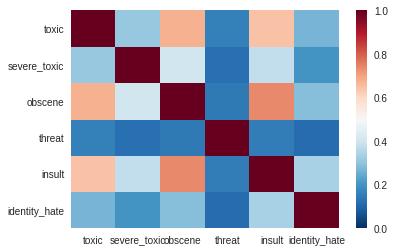

In [6]:
train_output_correlations = train_output.corr()
display(train_output_correlations)
graph.heatmap(train_output_correlations, vmin=0, vmax=1, center=0.5)

As we can see from the heatmap and the corrolation table, 
- Obscene and Insult ($R^2 = 0.741$)
- Obscene and Toxic ($R^2 = 0.677$)
- Insult and Toxic ($R^2 = 0.648$)

have the strongest relationships. We need to know if the $R^2$ is enough close to $1$ to search for a new feature to combine these classes.

## Data Set Cleaning
The goal is to remove noisy words because these words will hinder an accurate prediction.

- Comments contain noise like the words "the", "a", "I", "in", "do" and many others where their frequency should be the highest among the words used in the English language.
- We need to remove punctuations because they cause noise. For example, words "hello." and "hello" would have been counted as 2 words. Removing the puctuation (the ".") gives one word "hello" with frequency 2 instead of one.
- Remove usernames and IP addresses.
- Remove invisible characters like carriage returns.
- Set comments to lower case.
- Remove non ascii characters (e.g. Chinese characters).

In [7]:
train.comment_text = clean_text(train.comment_text)
test.comment_text = clean_text(test.comment_text)

words_frequency = GetWordFrequency(train.comment_text)

print("\nNumber of unique words: ", len(words_frequency))
print(words_frequency[:10])


Number of unique words:  183758
the     496506
to      297238
i       240000
of      224335
and     223985
you     218122
a       215865
is      176324
that    160717
it      148302
dtype: int64


# Training Models
The goal is to cross-validate our models on the train set to check if they predict accurately or not with the help of the roc-auc score and confusion matrices.

### Cross-Validation
We choose to split the train set in the following way:
- 50% of the train set is used as the training set
- 50% of the train set is used as the testing set

In [8]:
## Cross-validation: 
## X_train: 50% of train comments
## X_test: 50% of train output classes
## y_train: 50% of train comments used as test
## y_test: 50% of the train comments used as test
X_train, X_test, y_train, y_test = train_test_split(train.comment_text, 
                                                    train[output_classes], 
                                                    random_state=45, 
                                                    test_size=0.50)

## Naive Bayes Classifier Model
The goal is to apply the Naive Bayes classifier model on the training set and cross-validate with half of its data. However, this model has 2 major weaknesses:
- The model assumes that each word are independent between each other. This simplifies the problem but the assumption may be false because the context of the sentence may change completly the sense of words. For example: "Fuck yeah! I'm so happy now :-)". The word "Fuck" is used but knowing the context, the comment is not toxic at all.
- The model does not take in consideration puctuations, capital letters or invisible characters which could be good predictors.

### Predictions
Note that predictions returned are 
- probabilities for each class;
- 0 or 1 for each class where the threshold is set to $0.5$. If the probability $p \geq 0.5$, then return 1, otherwise 0.

For example, if the probability calculated is $p = 0.65$ that a comment is toxic, then the value 1 is returned for toxic class and 0 for non-toxic class because $0.65 > 0.5$. To get the confusion matrix, we need to get binary values (0 or 1). 

In [9]:
vectorizer = TfidfVectorizer(max_features=None, min_df=1)
X_train_vect = vectorizer.fit_transform(X_train)

X_test_vect = vectorizer.transform(X_test)

## Use the Naive Bayes Classifier Model.
classifier = MultinomialNB(alpha=0.015)

auc_roc_nb, predictions, predictions_int = calculate_predictions(classifier, X_train_vect, X_test_vect, y_train, y_test, output_classes)


Class:  toxic
ROC AUC:  0.9384636708876192

Class:  severe_toxic
ROC AUC:  0.9675340097383783

Class:  obscene
ROC AUC:  0.9471498549553693

Class:  threat
ROC AUC:  0.9407759337941329

Class:  insult
ROC AUC:  0.9492050680442392

Class:  identity_hate
ROC AUC:  0.9324457055662062

Multi-class ROC AUC:  0.9459290404976576


### Confusion Matrix

Confusion matrix, without normalization
[[71554   611]
 [ 3674  3947]]


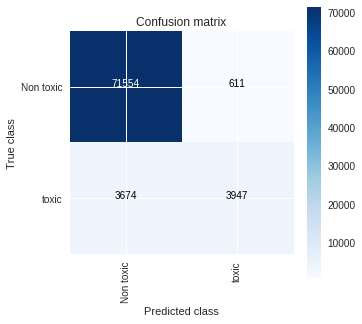

             precision    recall  f1-score   support

  Non toxic       0.95      0.99      0.97     72165
      toxic       0.87      0.52      0.65      7621

avg / total       0.94      0.95      0.94     79786

Confusion matrix, without normalization
[[78805   199]
 [  602   180]]


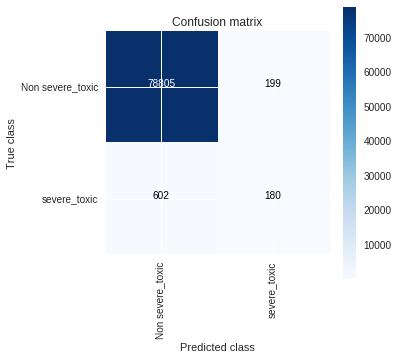

                  precision    recall  f1-score   support

Non severe_toxic       0.99      1.00      0.99     79004
    severe_toxic       0.47      0.23      0.31       782

     avg / total       0.99      0.99      0.99     79786

Confusion matrix, without normalization
[[75131   463]
 [ 1974  2218]]


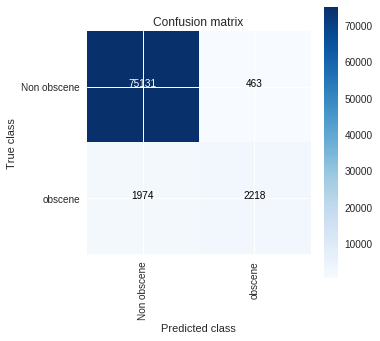

             precision    recall  f1-score   support

Non obscene       0.97      0.99      0.98     75594
    obscene       0.83      0.53      0.65      4192

avg / total       0.97      0.97      0.97     79786

Confusion matrix, without normalization
[[79555     9]
 [  215     7]]


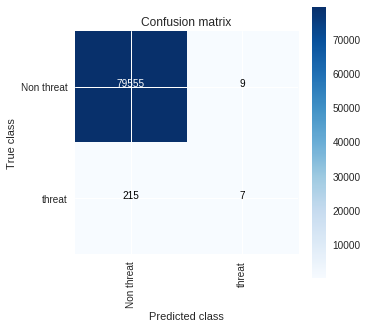

             precision    recall  f1-score   support

 Non threat       1.00      1.00      1.00     79564
     threat       0.44      0.03      0.06       222

avg / total       1.00      1.00      1.00     79786

Confusion matrix, without normalization
[[75377   588]
 [ 2003  1818]]


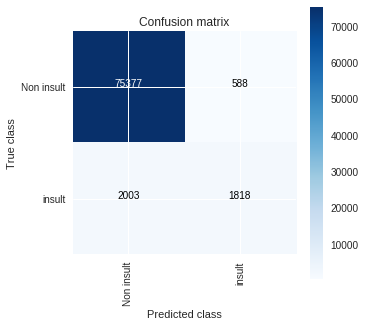

             precision    recall  f1-score   support

 Non insult       0.97      0.99      0.98     75965
     insult       0.76      0.48      0.58      3821

avg / total       0.96      0.97      0.96     79786

Confusion matrix, without normalization
[[79009   103]
 [  586    88]]


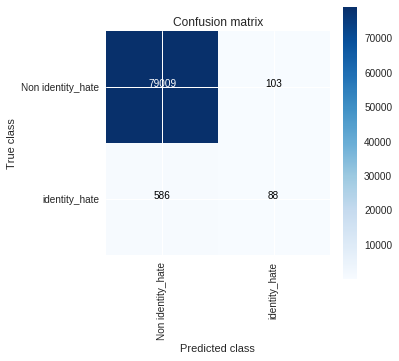

                   precision    recall  f1-score   support

Non identity_hate       0.99      1.00      1.00     79112
    identity_hate       0.46      0.13      0.20       674

      avg / total       0.99      0.99      0.99     79786



In [10]:
print_confusion_matrix_and_plot(y_test, predictions_int, output_classes)

In [11]:
for y_true, y_pred, comment in zip(y_test['threat'], predictions_int[:, 3], X_test):
    if(y_true == 0 and y_pred == 1):
        print("\n\n", comment)



 grandma terri should burn alive and be shot get shot asshole g mau f ck grandma terri in her old ass grandma terri i hope you die soon f ck you in the eye i hate you i want to shoot your ass grandma terri grandma terri you are shit grandma terri i wish you die die and go to hell grandma terri 


 hey i m just tellin like it is you ugly as fuck butt fugly muthafucka 


 grandma terri should burn in trash grandma terri is trash i hate grandma terri f k her to hell 


 grandma terri die in trash i f cking hate you grandma terri with all my heart soul mind and strength rot in trash grandma terri die now f ck you in the ass 


  dhudhi family  the dhudhi  are a tribe of panwar parmar rajput origin who numbered 5 800 according to the 1931 census of india the dhudhi have traditions of migration from malwa in central india dhudhi the ancestor of the tribe was said to be a kinsman of panwar ruler raja bhoj of ujjain and said to have migrated with his family to punjab history this is a clan o

### Area Under Curve ROC

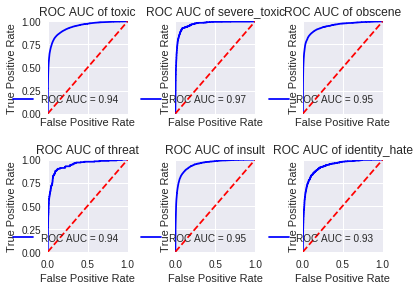

In [12]:
plot_auc_roc(output_classes, y_test, predictions, auc_roc_nb)

## Support Vector Machine Model


### Predictions

In [13]:
vectorizer = TfidfVectorizer(max_features=None, min_df=1)
X_train_vect = vectorizer.fit_transform(X_train)

X_test_vect = vectorizer.transform(X_test)

svm = LinearSVC(C=0.12)
classifier = CalibratedClassifierCV(svm)

auc_roc_svm, predictions, predictions_int = calculate_predictions(classifier, X_train_vect, X_test_vect, y_train, y_test, output_classes)


Class:  toxic
ROC AUC:  0.9713195222574766

Class:  severe_toxic
ROC AUC:  0.983841109213804

Class:  obscene
ROC AUC:  0.986607432051637

Class:  threat
ROC AUC:  0.9897822071732383

Class:  insult
ROC AUC:  0.9780887553537143

Class:  identity_hate
ROC AUC:  0.975246152170397

Multi-class ROC AUC:  0.9808141963700446


### Confusion Matrix

Confusion matrix, without normalization
[[71307   858]
 [ 2400  5221]]


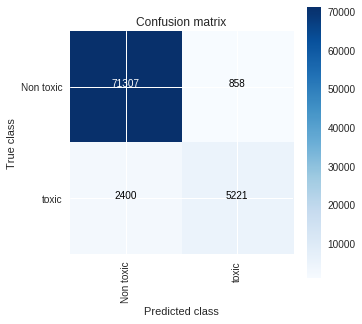

             precision    recall  f1-score   support

  Non toxic       0.97      0.99      0.98     72165
      toxic       0.86      0.69      0.76      7621

avg / total       0.96      0.96      0.96     79786

Confusion matrix, without normalization
[[78829   175]
 [  572   210]]


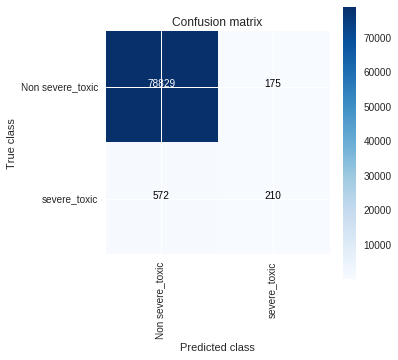

                  precision    recall  f1-score   support

Non severe_toxic       0.99      1.00      1.00     79004
    severe_toxic       0.55      0.27      0.36       782

     avg / total       0.99      0.99      0.99     79786

Confusion matrix, without normalization
[[75175   419]
 [ 1156  3036]]


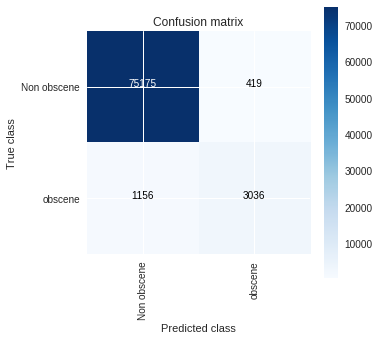

             precision    recall  f1-score   support

Non obscene       0.98      0.99      0.99     75594
    obscene       0.88      0.72      0.79      4192

avg / total       0.98      0.98      0.98     79786

Confusion matrix, without normalization
[[79505    59]
 [  166    56]]


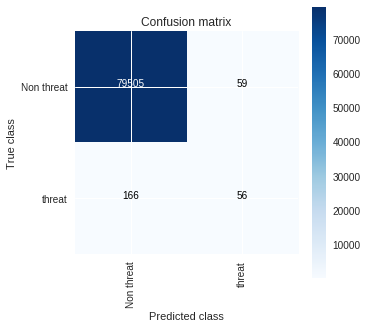

             precision    recall  f1-score   support

 Non threat       1.00      1.00      1.00     79564
     threat       0.49      0.25      0.33       222

avg / total       1.00      1.00      1.00     79786

Confusion matrix, without normalization
[[75378   587]
 [ 1527  2294]]


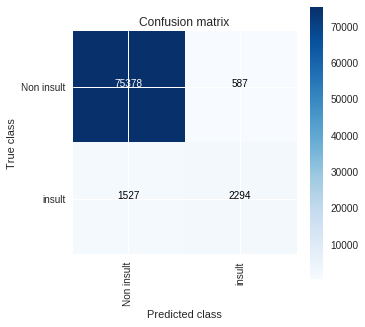

             precision    recall  f1-score   support

 Non insult       0.98      0.99      0.99     75965
     insult       0.80      0.60      0.68      3821

avg / total       0.97      0.97      0.97     79786

Confusion matrix, without normalization
[[78983   129]
 [  470   204]]


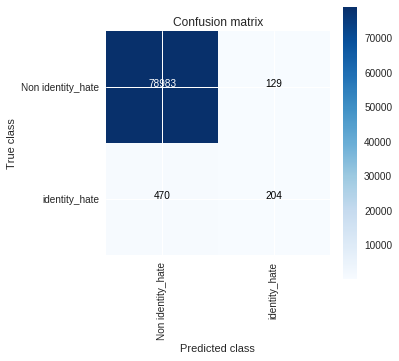

                   precision    recall  f1-score   support

Non identity_hate       0.99      1.00      1.00     79112
    identity_hate       0.61      0.30      0.41       674

      avg / total       0.99      0.99      0.99     79786



In [14]:
print_confusion_matrix_and_plot(y_test, predictions_int, output_classes)

### Area Under Curve ROC

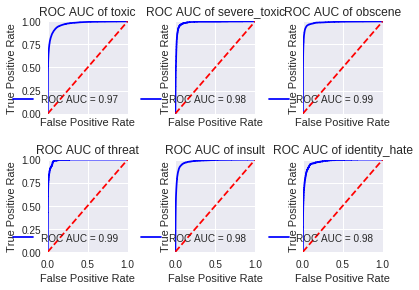

In [15]:
plot_auc_roc(output_classes, y_test, predictions, auc_roc_svm)

## Stochastic Gradient Descent Classifier Model

In [16]:
vectorizer = TfidfVectorizer(max_features=None, min_df=1)
X_train_vect = vectorizer.fit_transform(X_train)

X_test_vect = vectorizer.transform(X_test)

classifier = SGDClassifier(loss='log', penalty='l2', alpha=0.000004, max_iter=500)

auc_roc_sgd, predictions, predictions_int = calculate_predictions(classifier, X_train_vect, X_test_vect, y_train, y_test, output_classes)


Class:  toxic
ROC AUC:  0.9706966704051468

Class:  severe_toxic
ROC AUC:  0.9843757304010377

Class:  obscene
ROC AUC:  0.9841219248387376

Class:  threat
ROC AUC:  0.9870261393060649

Class:  insult
ROC AUC:  0.9765082881166107

Class:  identity_hate
ROC AUC:  0.9746474723286043

Multi-class ROC AUC:  0.9795627042327002


### Confusion Matrix

Confusion matrix, without normalization
[[71598   567]
 [ 2751  4870]]


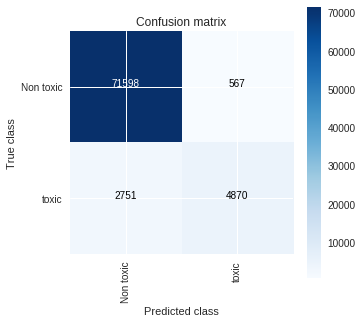

             precision    recall  f1-score   support

  Non toxic       0.96      0.99      0.98     72165
      toxic       0.90      0.64      0.75      7621

avg / total       0.96      0.96      0.96     79786

Confusion matrix, without normalization
[[78849   155]
 [  585   197]]


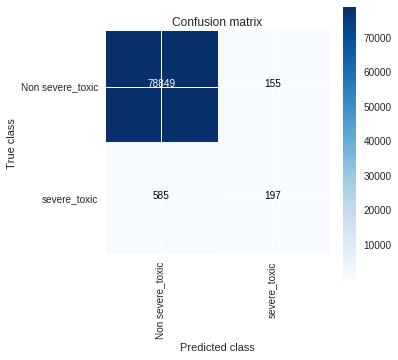

                  precision    recall  f1-score   support

Non severe_toxic       0.99      1.00      1.00     79004
    severe_toxic       0.56      0.25      0.35       782

     avg / total       0.99      0.99      0.99     79786

Confusion matrix, without normalization
[[75311   283]
 [ 1437  2755]]


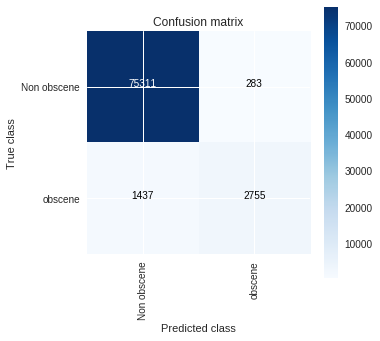

             precision    recall  f1-score   support

Non obscene       0.98      1.00      0.99     75594
    obscene       0.91      0.66      0.76      4192

avg / total       0.98      0.98      0.98     79786

Confusion matrix, without normalization
[[79542    22]
 [  188    34]]


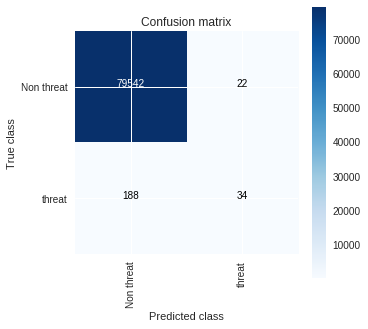

             precision    recall  f1-score   support

 Non threat       1.00      1.00      1.00     79564
     threat       0.61      0.15      0.24       222

avg / total       1.00      1.00      1.00     79786

Confusion matrix, without normalization
[[75459   506]
 [ 1664  2157]]


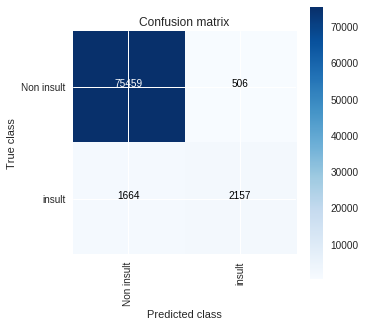

             precision    recall  f1-score   support

 Non insult       0.98      0.99      0.99     75965
     insult       0.81      0.56      0.67      3821

avg / total       0.97      0.97      0.97     79786

Confusion matrix, without normalization
[[79038    74]
 [  522   152]]


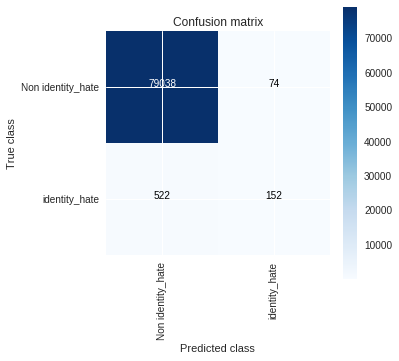

                   precision    recall  f1-score   support

Non identity_hate       0.99      1.00      1.00     79112
    identity_hate       0.67      0.23      0.34       674

      avg / total       0.99      0.99      0.99     79786



In [17]:
print_confusion_matrix_and_plot(y_test, predictions_int, output_classes)

### Area Under Curve ROC

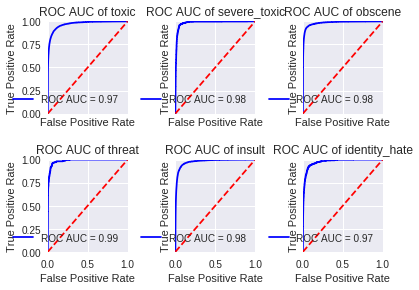

In [18]:
plot_auc_roc(output_classes, y_test, predictions, auc_roc_sgd)

## Extreme Gradient Boosting Tree Model


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Class:  toxic
ROC AUC:  0.7643516681421576


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Class:  severe_toxic
ROC AUC:  0.8465464000592544


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Class:  obscene
ROC AUC:  0.7721523823304164


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Class:  threat
ROC AUC:  0.8042187749813059


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Class:  insult
ROC AUC:  0.7692663908620708

Class:  identity_hate
ROC AUC:  0.7383481590011143

Multi-class ROC AUC:  0.7824806292293865


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


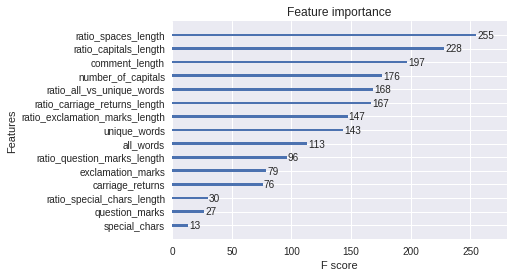

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train[new_features], 
                                                    train[output_classes], 
                                                    random_state=45, 
                                                    test_size=0.50)

params = {
    'n_estimators': 300,
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'eval_metric': 'auc',
    'seed': 1024
}

classifier = xgb.XGBClassifier(**params)

auc_roc_xgb, predictions, predictions_int = calculate_predictions(classifier, X_train, X_test, y_train, y_test, output_classes)

xgb.plot_importance(classifier)
plt.show()

### Confusion Matrix

Confusion matrix, without normalization
[[71552   613]
 [ 6593  1028]]


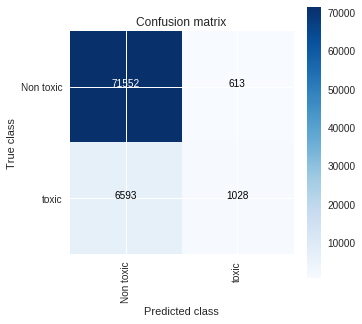

             precision    recall  f1-score   support

  Non toxic       0.92      0.99      0.95     72165
      toxic       0.63      0.13      0.22      7621

avg / total       0.89      0.91      0.88     79786

Confusion matrix, without normalization
[[78958    46]
 [  757    25]]


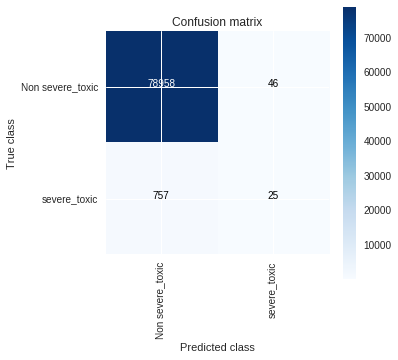

                  precision    recall  f1-score   support

Non severe_toxic       0.99      1.00      0.99     79004
    severe_toxic       0.35      0.03      0.06       782

     avg / total       0.98      0.99      0.99     79786

Confusion matrix, without normalization
[[75337   257]
 [ 3962   230]]


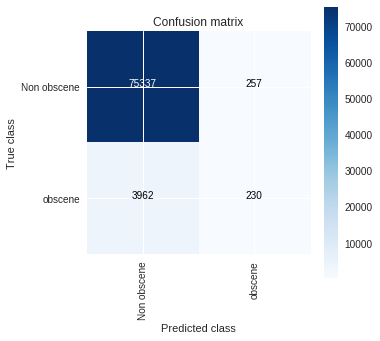

             precision    recall  f1-score   support

Non obscene       0.95      1.00      0.97     75594
    obscene       0.47      0.05      0.10      4192

avg / total       0.92      0.95      0.93     79786

Confusion matrix, without normalization
[[79562     2]
 [  222     0]]


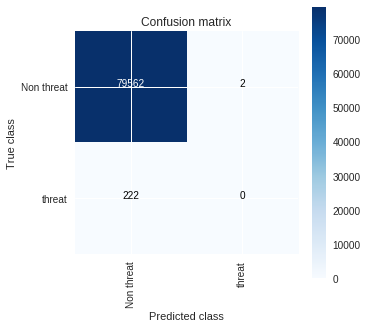

             precision    recall  f1-score   support

 Non threat       1.00      1.00      1.00     79564
     threat       0.00      0.00      0.00       222

avg / total       0.99      1.00      1.00     79786

Confusion matrix, without normalization
[[75735   230]
 [ 3665   156]]


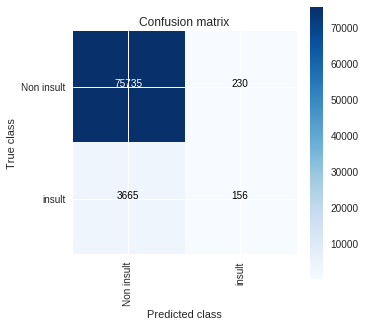

             precision    recall  f1-score   support

 Non insult       0.95      1.00      0.97     75965
     insult       0.40      0.04      0.07      3821

avg / total       0.93      0.95      0.93     79786

Confusion matrix, without normalization
[[79109     3]
 [  674     0]]


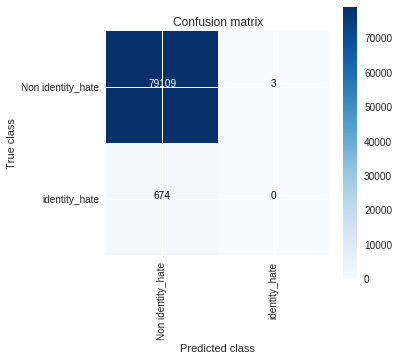

                   precision    recall  f1-score   support

Non identity_hate       0.99      1.00      1.00     79112
    identity_hate       0.00      0.00      0.00       674

      avg / total       0.98      0.99      0.99     79786



In [20]:
print_confusion_matrix_and_plot(y_test, predictions_int, output_classes)

### Area Under Curve ROC

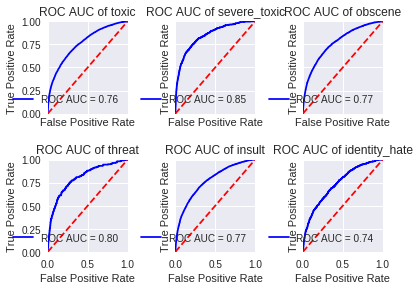

In [21]:
plot_auc_roc(output_classes, y_test, predictions, auc_roc_xgb)

## Random Forest Model

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train[new_features], 
                                                    train[output_classes], 
                                                    random_state=45, 
                                                    test_size=0.50)
params = {
    'n_estimators': 700,
    'criterion': 'entropy'
}

classifier = RandomForestClassifier(**params)

auc_roc_rf, predictions, predictions_int = calculate_predictions(classifier, X_train, X_test, y_train, y_test, output_classes)


Class:  toxic
ROC AUC:  0.7198805200939655

Class:  severe_toxic
ROC AUC:  0.7658851745147807

Class:  obscene
ROC AUC:  0.7236095972316555

Class:  threat
ROC AUC:  0.7176829656311581

Class:  insult
ROC AUC:  0.7170692942122532

Class:  identity_hate
ROC AUC:  0.6623388960938225

Multi-class ROC AUC:  0.7177444079629393


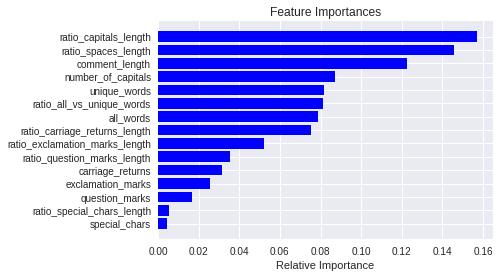

In [23]:
importances = classifier.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlabel('Relative Importance')
plt.yticks(range(len(indices)), [new_features[i] for i in indices])
plt.show()

### Confusion Matrix

Confusion matrix, without normalization
[[70949  1216]
 [ 6433  1188]]


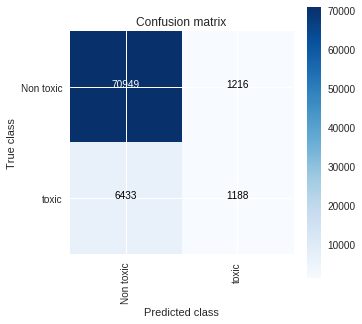

             precision    recall  f1-score   support

  Non toxic       0.92      0.98      0.95     72165
      toxic       0.49      0.16      0.24      7621

avg / total       0.88      0.90      0.88     79786

Confusion matrix, without normalization
[[78943    61]
 [  753    29]]


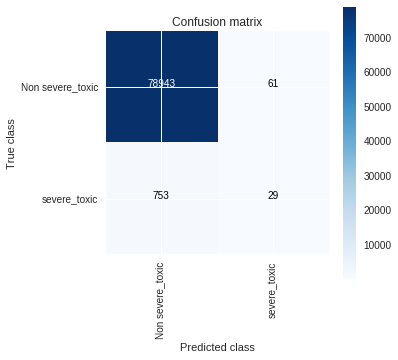

                  precision    recall  f1-score   support

Non severe_toxic       0.99      1.00      0.99     79004
    severe_toxic       0.32      0.04      0.07       782

     avg / total       0.98      0.99      0.99     79786

Confusion matrix, without normalization
[[75080   514]
 [ 3915   277]]


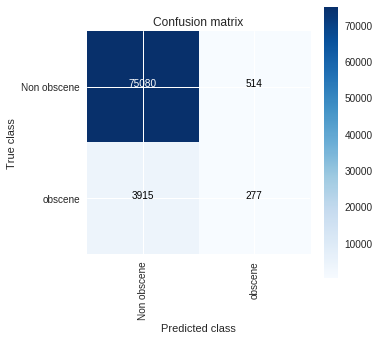

             precision    recall  f1-score   support

Non obscene       0.95      0.99      0.97     75594
    obscene       0.35      0.07      0.11      4192

avg / total       0.92      0.94      0.93     79786

Confusion matrix, without normalization
[[79557     7]
 [  220     2]]


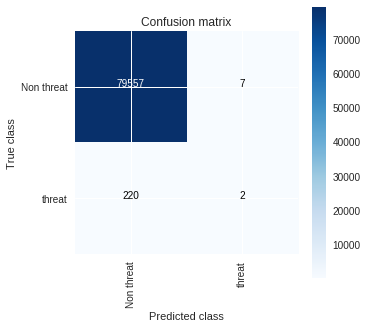

             precision    recall  f1-score   support

 Non threat       1.00      1.00      1.00     79564
     threat       0.22      0.01      0.02       222

avg / total       1.00      1.00      1.00     79786

Confusion matrix, without normalization
[[75490   475]
 [ 3627   194]]


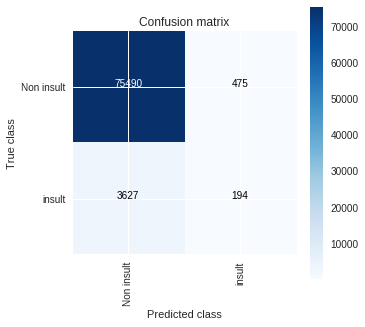

             precision    recall  f1-score   support

 Non insult       0.95      0.99      0.97     75965
     insult       0.29      0.05      0.09      3821

avg / total       0.92      0.95      0.93     79786

Confusion matrix, without normalization
[[79061    51]
 [  673     1]]


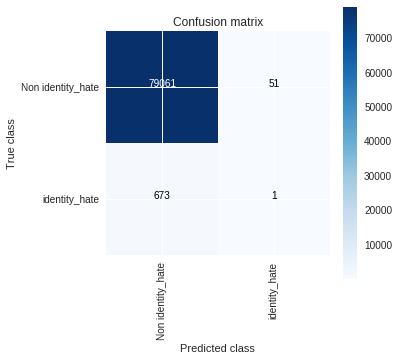

                   precision    recall  f1-score   support

Non identity_hate       0.99      1.00      1.00     79112
    identity_hate       0.02      0.00      0.00       674

      avg / total       0.98      0.99      0.99     79786



In [24]:
print_confusion_matrix_and_plot(y_test, predictions_int, output_classes)

### Area Under Curve ROC

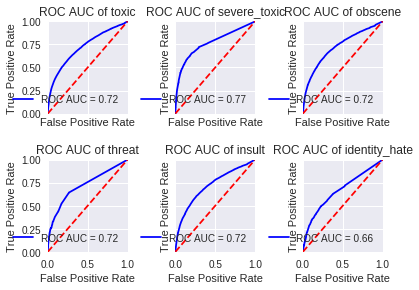

In [25]:
plot_auc_roc(output_classes, y_test, predictions, auc_roc_rf)

# Conclusion

## Summary of Models
We show the AUROC scores obtained from models we tested.

In [26]:
models = {
    'model': ['Linear SVM Regularized', 'Stochastic Gradient Descent', 'Multinomial Naive Bayes', 'Extreme Gradient Boosting Tree', 'Random Forest'],
    'score': [np.mean(auc_roc_svm), np.mean(auc_roc_sgd), np.mean(auc_roc_nb), np.mean(auc_roc_xgb), np.mean(auc_roc_rf)]
}
summary = pandas.DataFrame(models)
display(summary)

,model,score
0,Linear SVM Regularized,0.9808
1,Stochastic Gradient Descent,0.9796
2,Multinomial Naive Bayes,0.9459
3,Extreme Gradient Boosting Tree,0.7825
4,Random Forest,0.7177


From the scores of models, we select the Linear SVM Regularized classifier model to predict the real test set.

## Best Model Predictions
From the AUROC score we got, the support vector machine is the best one. Therefore, we use this model to get the prediction probabilities of each class using the comments from the test set.

In [27]:
vectorizer = TfidfVectorizer(max_features=None, min_df=1)
X_train_vect = vectorizer.fit_transform(train.comment_text)
X_test_vect = vectorizer.transform(test.comment_text)

svm = LinearSVC(C=0.12)
classifier = CalibratedClassifierCV(svm)

submission = pandas.read_csv('dataset/sample_submission.csv')

for i, output_class in enumerate(output_classes): 
    ## Training from the train set data.
    classifier.fit(X_train_vect, train[output_class])

    ## From what's learned when training, predict the class of each comment of the test set. 
    submission[output_class] = classifier.predict_proba(X_test_vect)[:, 1]

print(submission[output_classes])

        toxic  severe_toxic  obscene  threat  insult  identity_hate
0      1.0000        0.1418   0.9999  0.0262  0.9884         0.1424
1      0.0038        0.0021   0.0029  0.0004  0.0057         0.0036
2      0.0245        0.0049   0.0122  0.0011  0.0163         0.0044
3      0.0019        0.0033   0.0032  0.0009  0.0049         0.0012
4      0.0161        0.0023   0.0060  0.0013  0.0078         0.0027
5      0.0045        0.0022   0.0040  0.0011  0.0083         0.0020
6      0.0028        0.0008   0.0046  0.0003  0.0063         0.0013
7      0.5018        0.0021   0.0259  0.0014  0.0561         0.0032
8      0.0053        0.0020   0.0065  0.0008  0.0068         0.0021
9      0.0024        0.0009   0.0043  0.0005  0.0055         0.0019
10     0.4301        0.0005   0.0905  0.0002  0.0053         0.0022
11     0.1546        0.0020   0.0219  0.0016  0.0163         0.0046
12     0.0028        0.0016   0.0032  0.0004  0.0035         0.0007
13     0.0043        0.0016   0.0075  0.0003  0.

## Submission of Results

In [28]:
submission.to_csv('submission_SVM.csv', index=False)

# Recommendation
